# Out-of-the-box PCA Analysis

## Example dataset
Replication data from a behavioral economic field experiment in Turkish schools. 

Alan, Sule; Boneva, Teodora; Ertac, Seda, 2019, "Replication Data for: 'Ever Failed, Try Again, Succeed Better: Results from a Randomized Educational Intervention on Grit'", https://doi.org/10.7910/DVN/SAVGAL, Harvard Dataverse, V1.


### Setting

You cleaned the data from missings, standardized it and want to inpsect its properties by applying PCA.

### Solution

Apply `do_pca()` to dataframe which containts standardized features and obtain: 

* *Explained variance*: See how much each PC captures
* *Latent factors*: Inspect factor loadings with heatmap


Lastly, Apply Kmeans clustering to uncover patterns and plot PCs grouped by kmean's labels.

### Ensure

* select features (X)
* numeric type
* no missings (removed or imputed)
* standardize

# Preface
## Import modules

In [1]:
import pandas as pd
import numpy as np

#sklearn modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#plots
import matplotlib.pyplot as plt
import seaborn as sns
# seaborn settings
sns.set_style("whitegrid")
sns.set_context("talk")

print("RUNNING ON")
!python --version
print('Pandas ',pd.__version__)
print('Numpy', np.__version__)
print('Seaborn ',sns.__version__)

RUNNING ON
Python 3.7.6
Pandas  1.0.3
Numpy 1.18.1
Seaborn  0.10.0


## Build function for one-shot preprocessing and engineering 
### Assure

* select features (X)
* all numeric type
* no missings (removed or imputed)
* standardize

In [2]:


def clean_data(data, select_X=None, impute=False, std=False): 
    """Returns dataframe with standardized and imputed features if necessary
    
    Input
          data: dataframe
          select_X: list of feature names to be selected (string)
          impute: If True impute np.nan with mean
          std: If True standardize data
          
    Return
        dataframe: data with selected, imputed and standardized features    
    """
    
    if select_X is not None:
        # select features
        data = data.filter(select_X, axis='columns')
        print("\t>>> Selected features: {}".format(select_X))
    else:
        # store column names
        select_X = list(data.columns)
    
    if impute:
        # impute with mean 
        imp = SimpleImputer()
        data = imp.fit_transform(data)
        print("\t>>> Imputed missings")
    
    if std:
        # standardize 
        std_scaler = StandardScaler()
        data = std_scaler.fit_transform(data)
        print("\t>>> Standardized data")
    
    return pd.DataFrame(data, columns=select_X)

# Load raw data from Dataverse

In [ ]:
# To load data from Harvard Dataverse
import io 
import requests 

# load exciting data from URL (at least something else than Iris)
url = 'https://dataverse.harvard.edu/api/access/datafile/3352340?gbrecs=false'
s = requests.get(url).content

# store as dataframe
df_raw = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')

print("Data loaded from Harvard Dataverse.")

# Preprocessing and engineering
## Select features, impute missings and standardize

In [24]:
# select relevant features in line with Alan et al. (2019)
selected_features = ['grit', 'male', 'task_ability', 'raven', 'grit_survey1', 
 'belief_survey1', 'mathscore1', 'verbalscore1', 'risk', 'inconsistent']

# convenience function: clean_data --> select features, impute missings, standardize
X_std = clean_data(df_raw, selected_features, impute=True, std=True)

Data loaded from Harvard Dataverse.
Selected features: ['grit', 'male', 'task_ability', 'raven', 'grit_survey1', 'belief_survey1', 'mathscore1', 'verbalscore1', 'risk', 'inconsistent']
Imputed missings
Standardized data


# Main part: PCA
## Initialize

In [4]:
# initialize and compute pca
pca = PCA()
X_pca = pca.fit_transform(X_std)

## Inspect properties: I. explained variance

In [5]:
# get basic info
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1

df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

# DISPLAY info about PCs
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 10 components
----------------------------------------
Mean explained variance: 0.1
----------------------------------------
    explained variance  cumulative
1             0.265261    0.265261
2             0.122700    0.387962
3             0.113990    0.501951
4             0.099139    0.601090
5             0.094357    0.695447
6             0.083412    0.778859
7             0.063117    0.841976
8             0.056386    0.898362
9             0.052588    0.950950
10            0.049050    1.000000
----------------------------------------


### Visualize explained variance: Scree plot

Limit scree plot to nth component (0 for all) > 0


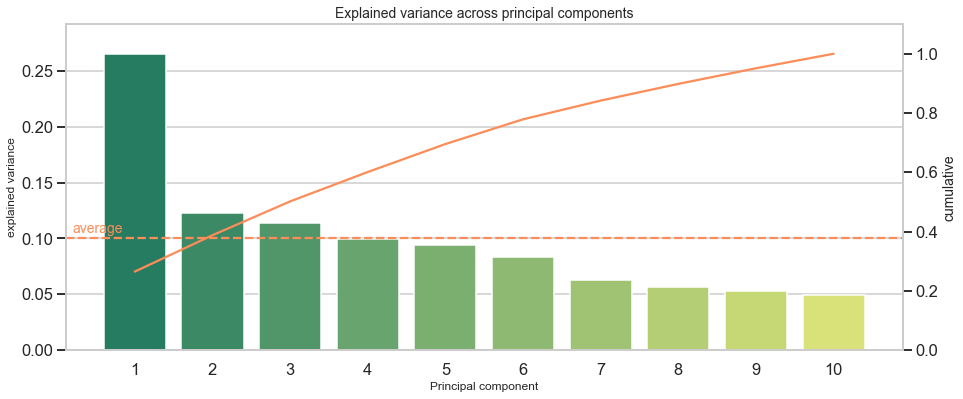

In [6]:
#limit plot to x PC
limit = int(input("Limit scree plot to nth component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components

df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]

#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)

ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis

max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

## Inspect properties: II. Correlations of features and components (factor loadings)

In [29]:
############### DEFINE PARAMS
top_k = 3
#select data based on percentile (top_q) or top-k features
top_q = .50
top_pc = 3
###############

# PCA factor loadings
df_c = pd.DataFrame(pca.components_, columns=selected_features).T

print("Factor Loadings for the 1. component \n(explains {0:.2f} of the variance)".format(df_explained_variance.iloc[0,0]))
print('='*40,'\n')
print('Top {} highest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

print('Top {} lowest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values()[:top_k])

Factor Loadings for the 1. component 
(explains 0.27 of the variance)

Top 3 highest
----------------------------------------
inconsistent    0.093082
male            0.084360
grit            0.048657
Name: 0, dtype: float64 

Top 3 lowest
----------------------------------------
mathscore1     -0.467809
raven          -0.452894
grit_survey1   -0.452138
Name: 0, dtype: float64


### Visualize factor loadings: Heatmap

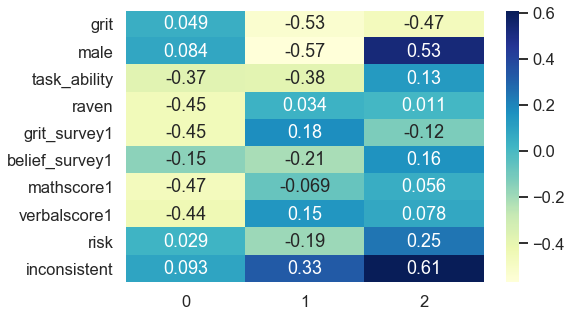

In [9]:
# Plot heatmap
size_yaxis = round(X_std.shape[1] * 0.5)

fig, ax = plt.subplots(figsize=(8,size_yaxis))
sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
plt.show()

# All-in-one Function
## `do_pca()`

A convenient function as a shortcut to PCA. 

>**Input**: standardized features (X_std)

    1. Conducts a PCA on standardized data 
    2. Lists explained variance for each component
    2. scree plot (explained variance of components)
    3. heatmap of factor loadings (correlations of features with components)
    4. Returns a PCA object and the PCA tranformation of the data

>**Return:** PCA object and the PCA tranformation of the data

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

#plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

def do_pca(data_std, feature_names=None, top_k=10, top_pc=10):
    """Conduct a PCA on standardized data. Show scree plot and heatmap of factor loadings. 
        Returns a PCA object and the PCA tranformation of the data.
     
    Input
        data_std: dataframe containing standardized data
        feature_names: list of features 
        top_k: Top-k variables to list for factor loadings
        top_pc: Show PC up to top_pc in scree plot and heatmap 
        
    Return 
        tuple: (pca object, pca transformation)
    """
    # store feature names if not given
    if feature_names is None:
        feature_names = list(data_std.columns)
    
    #---------------
    ### 1.
    # initialize and compute pca
    pca = PCA()
    X_pca = pca.fit_transform(data_std)
    
    
    #---------------
    ### 2.
    # print explained variance for each component
    n_components = len(pca.explained_variance_ratio_)
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    idx = np.arange(n_components)+1

    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                         index=['explained variance', 'cumulative'], 
                                         columns=idx).T

    mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

    print('PCA Overview')
    print('='*40)
    print("Total: {} components".format(n_components))
    print('-'*40)
    print('Mean explained variance:', round(mean_explained_variance,3))
    print('-'*40)
    print(df_explained_variance.head(20))
    print('-'*40)
    
    
    #---------------
    ### 3. 
    # Explained variance plot (scree plot)
    df_explained_variance_limited = df_explained_variance.iloc[:top_pc,:]

    fig, ax1 = plt.subplots(figsize=(15,6))

    ax1.set_title('Explained variance across principal components', fontsize=14)
    ax1.set_xlabel('Principal component', fontsize=12)
    ax1.set_ylabel('Explained variance', fontsize=12)

    ax2 = sns.barplot(x=idx[:top_pc], y='explained variance', data=df_explained_variance_limited, palette='YlGnBu')
    ax2 = ax1.twinx()
    ax2.grid(False)

    ax2.set_ylabel('Cumulative', fontsize=14)
    ax2 = sns.lineplot(x=idx[:top_pc]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

    ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
    #label y axis
    ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) 

    max_y1 = max(df_explained_variance_limited.iloc[:,0])
    max_y2 = max(df_explained_variance_limited.iloc[:,1])
    ax1.set(ylim=(0, max_y1+max_y1*.1))
    ax2.set(ylim=(0, max_y2+max_y2*.1))

    plt.show()
    
    
    #---------------
    ### 4. 
    # Correlations of features with components
    df_c = pd.DataFrame(pca.components_, columns=feature_names).T

    print("Factor Loadings of 1st PC")
    print('='*40,'\n')
    print('Top {} highest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

    print('Top {} lowest'.format(top_k))
    print('-'*40)
    print(df_c.iloc[:,0].sort_values()[:top_k])
    
    # Plot heatmap
    size_xaxis = round(top_pc * 1.5)
    size_yaxis = round(n_components * 0.5)

    fig, ax = plt.subplots(figsize=(size_xaxis,size_yaxis))
    sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
    plt.show()
    
    #---------------
    ### 5.
    # Pca object and transformed data
    return pca, pd.DataFrame(X_pca)

PCA Overview
Total: 10 components
----------------------------------------
Mean explained variance: 0.1
----------------------------------------
    explained variance  cumulative
1             0.265261    0.265261
2             0.122700    0.387962
3             0.113990    0.501951
4             0.099139    0.601090
5             0.094357    0.695447
6             0.083412    0.778859
7             0.063117    0.841976
8             0.056386    0.898362
9             0.052588    0.950950
10            0.049050    1.000000
----------------------------------------


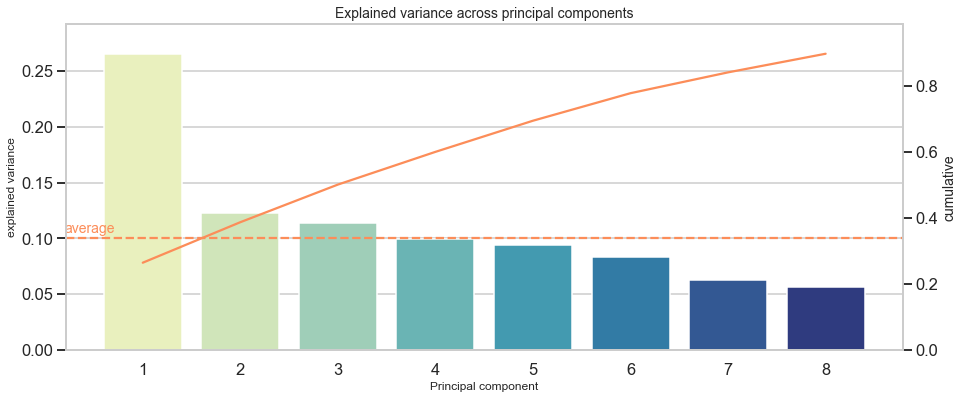

Factor Loadings of 1st PC

Top 5 highest
----------------------------------------
inconsistent      0.093082
male              0.084360
grit              0.048657
risk              0.029110
belief_survey1   -0.153302
Name: 0, dtype: float64 

Top 5 lowest
----------------------------------------
mathscore1     -0.467809
raven          -0.452894
grit_survey1   -0.452138
verbalscore1   -0.435924
task_ability   -0.372942
Name: 0, dtype: float64


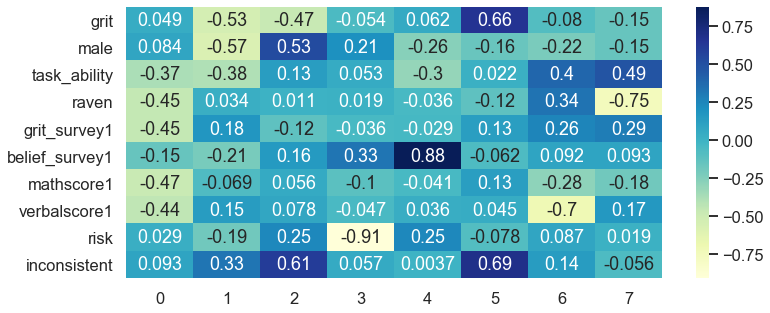

In [19]:
pca, X_pca = do_pca(X_std, top_pc=8, top_k=5)

# Compare to Wine dataset

	>>> Standardized data
PCA Overview
Total: 13 components
----------------------------------------
Mean explained variance: 0.077
----------------------------------------
    explained variance  cumulative
1             0.361988    0.361988
2             0.192075    0.554063
3             0.111236    0.665300
4             0.070690    0.735990
5             0.065633    0.801623
6             0.049358    0.850981
7             0.042387    0.893368
8             0.026807    0.920175
9             0.022222    0.942397
10            0.019300    0.961697
11            0.017368    0.979066
12            0.012982    0.992048
13            0.007952    1.000000
----------------------------------------


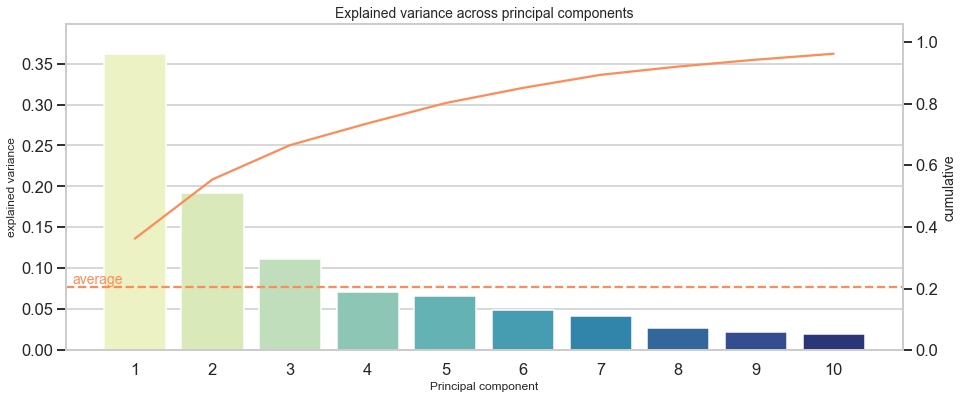

Factor Loadings of 1st PC

Top 10 highest
----------------------------------------
flavanoids                      0.422934
total_phenols                   0.394661
od280/od315_of_diluted_wines    0.376167
proanthocyanins                 0.313429
hue                             0.296715
proline                         0.286752
alcohol                         0.144329
magnesium                       0.141992
ash                            -0.002051
color_intensity                -0.088617
Name: 0, dtype: float64 

Top 10 lowest
----------------------------------------
nonflavanoid_phenols   -0.298533
malic_acid             -0.245188
alcalinity_of_ash      -0.239320
color_intensity        -0.088617
ash                    -0.002051
magnesium               0.141992
alcohol                 0.144329
proline                 0.286752
hue                     0.296715
proanthocyanins         0.313429
Name: 0, dtype: float64


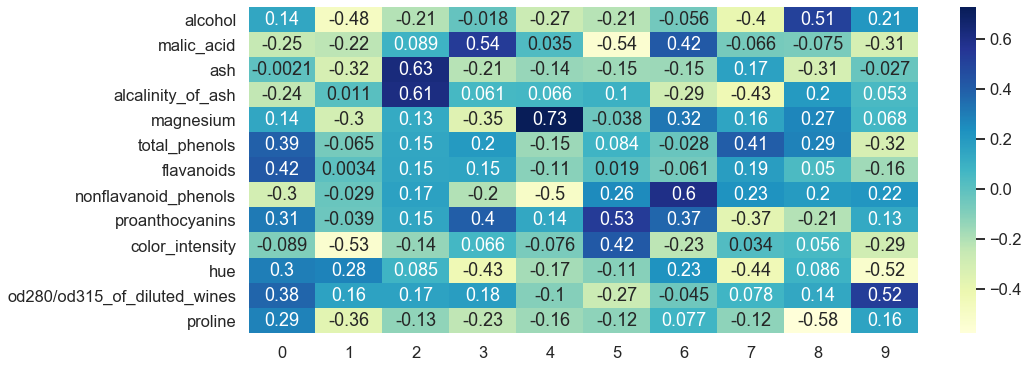

In [26]:
from sklearn import datasets

# import some data to play with
X_wine, y_wine = datasets.load_wine(return_X_y=True)
wine_feature_names = datasets.load_wine().feature_names

X_wine_std = clean_data(pd.DataFrame(X_wine), std=True)
pca, X_wine_pca = do_pca(X_wine_std, feature_names=wine_feature_names)

# Compare to Boston Housing dataset

	>>> Standardized data
PCA Overview
Total: 13 components
----------------------------------------
Mean explained variance: 0.077
----------------------------------------
    explained variance  cumulative
1             0.471296    0.471296
2             0.110252    0.581548
3             0.095586    0.677134
4             0.065967    0.743101
5             0.064217    0.807318
6             0.050570    0.857888
7             0.041181    0.899069
8             0.030469    0.929538
9             0.021303    0.950841
10            0.016941    0.967783
11            0.014309    0.982091
12            0.013023    0.995115
13            0.004885    1.000000
----------------------------------------


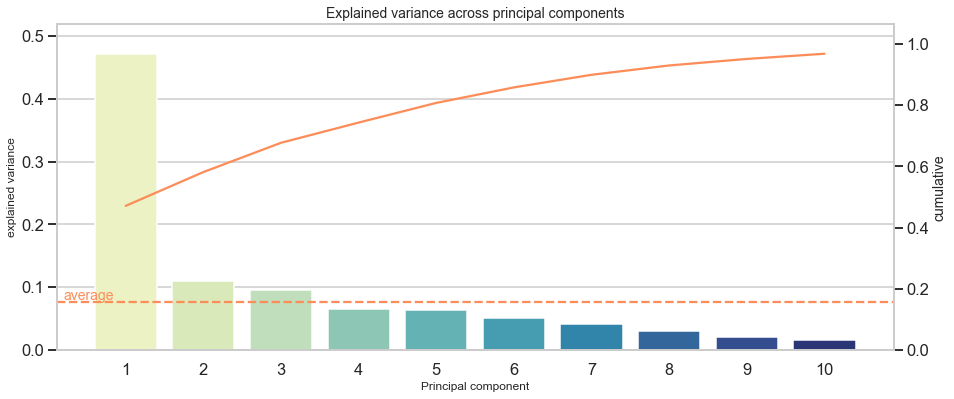

Factor Loadings of 1st PC

Top 5 highest
----------------------------------------
INDUS    0.346672
NOX      0.342852
TAX      0.338469
RAD      0.319793
AGE      0.313671
Name: 0, dtype: float64 

Top 5 lowest
----------------------------------------
DIS    -0.321544
ZN     -0.256315
B      -0.202973
RM     -0.189243
CHAS    0.005042
Name: 0, dtype: float64


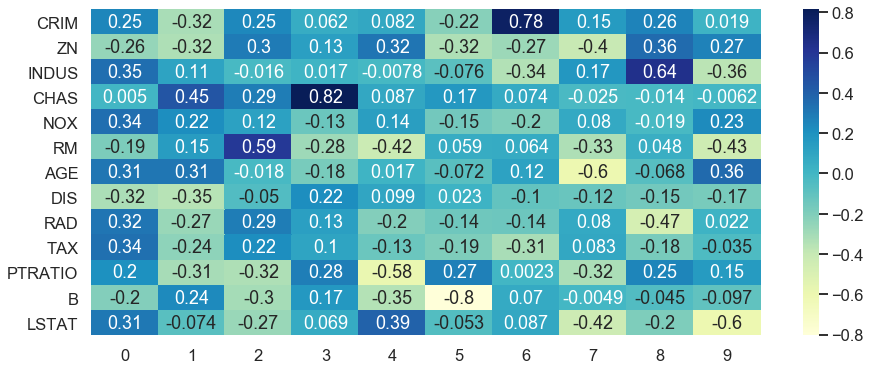

In [23]:
from sklearn import datasets

# import some data to play with
X_boston, y_boston = datasets.load_boston(return_X_y=True)
boston_feature_names = datasets.load_boston().feature_names
X_boston_std = clean_data(pd.DataFrame(X_boston), std=True)
pca, X_boston_pca = do_pca(X_boston_std, feature_names=boston_feature_names, top_k=5)

# Compare to Iris dataset

	>>> Standardized data
PCA Overview
Total: 4 components
----------------------------------------
Mean explained variance: 0.25
----------------------------------------
   explained variance  cumulative
1            0.729624    0.729624
2            0.228508    0.958132
3            0.036689    0.994821
4            0.005179    1.000000
----------------------------------------


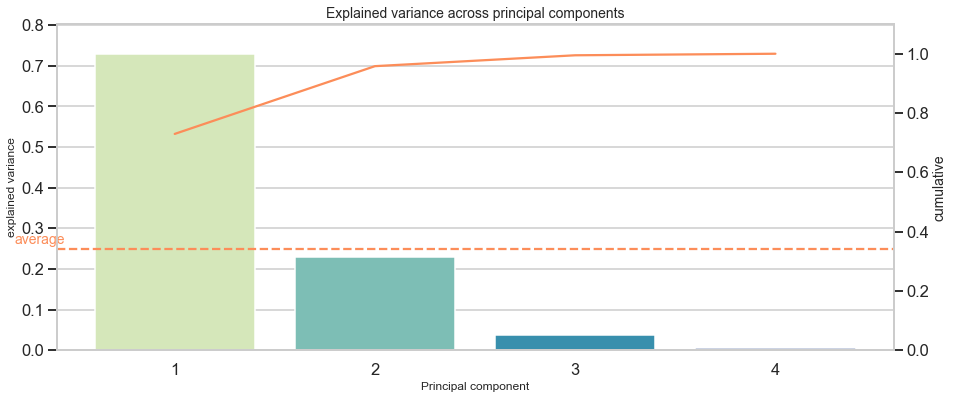

Factor Loadings of 1st PC

Top 10 highest
----------------------------------------
petal length (cm)    0.580413
petal width (cm)     0.564857
sepal length (cm)    0.521066
sepal width (cm)    -0.269347
Name: 0, dtype: float64 

Top 10 lowest
----------------------------------------
sepal width (cm)    -0.269347
sepal length (cm)    0.521066
petal width (cm)     0.564857
petal length (cm)    0.580413
Name: 0, dtype: float64


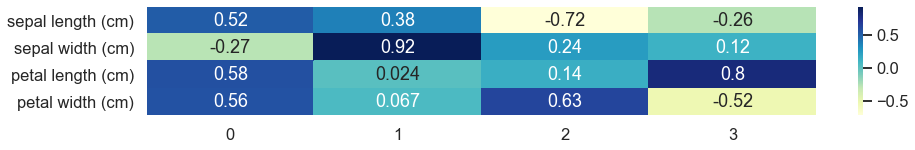

In [31]:
from sklearn import datasets

# import some data to play with
X_iris, y_iris = datasets.load_iris(return_X_y=True)
iris_feature_names = datasets.load_iris().feature_names
X_iris_std = clean_data(pd.DataFrame(X_iris), std=True)
pca, X_pca = do_pca(X_iris_std, feature_names=iris_feature_names)

# Factor analysis for comparison

In [168]:
from sklearn.decomposition import FactorAnalysis

factor = FactorAnalysis(n_components=10, random_state=42).fit(X_std)

plot = pd.DataFrame(factor.components_,columns=selected_features).T

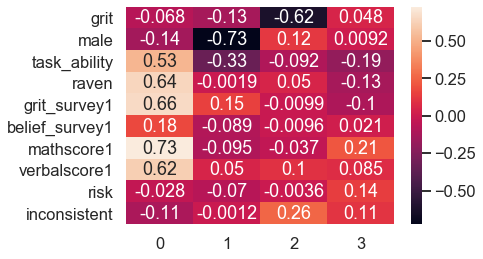

In [171]:
sns.heatmap(plot, annot=True)

# KMeans Clustering

In [50]:
# Sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import itertools #for unordered pairwise combinations of list elements

# Over a number of different cluster counts...
    # run k-means clustering on the data and...

def k_mean_distance(data, centroid_x, centroid_i, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-centroid_x) for x in data[cluster_labels == centroid_i]]
    # return the mean value
    return np.mean(distances)

def get_kmeans_model(data, k):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    clusters = model.fit_predict(data) #cluster labels
    centroids = model.cluster_centers_ #cluster centroids
    
    #SCORE METHOD: Average distance to cluster

    c_mean_distances = []    
    for i, cent_features in enumerate(centroids):
        mean_distance = k_mean_distance(data, cent_features, i, clusters)
        c_mean_distances.append(mean_distance)

    score = np.array(c_mean_distances).mean()
    
    return model, score

#TODO: nicer progress bar
scores = []
k_list = list(range(5,100,10))

for k in k_list:
    print(f">> Compute {k} clusters, progress: {int(k_list.index(k)/len(k_list)*100)}%")
    s = get_kmeans_model(X_pca, k)[1]
    scores.append(s)

# Investigate the change in within-cluster distance across number of clusters.
plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Mean distance to cluster center');
plt.title('Mean distance to cluster center across K');

In [120]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions
optimal_k = int(input("Estimate the optimal k: "))
k_means_selected = KMeans(n_clusters=optimal_k, random_state=42)
k_means_selected.fit(X_pca)
preds = k_means_selected.predict(X_pca)
df_clusters = pd.concat([pd.DataFrame(X_pca), pd.Series(preds, name='cluster')], axis=1)

Estimate the optimal k: 16


In [121]:
def plot_cluster_pca(cluster_data, k, n_pc=3):
    #TODO: plot 3 in one row using subplots and ax
    #TODO: plot in nicer dims
#     dims = (11.7, 8.27)
    for i in itertools.combinations(range(n_pc),2):
        g = sns.scatterplot(data=cluster_data, hue='cluster', x=i[0], y=i[1])
    #     g._legend.remove()
        g.set(xlabel='PCA {}'.format(i[0]+1), ylabel='PCA {}'.format(i[1]+1), title=f"PCs by KMeans clusters  (k={k})")
    #     g.plt.set_size_inches(dims)
        plt.show()

plot_cluster_pca(df_clusters, optimal_k)

# Dump
### Factor loadings definition

Each component is a linear combination of features

Factor loadings indicate to what extent each feature is associated with a component. For example, cognitive ability has a high factor loading for the first component, which explains a lot 

Components are linear combinations of features. 

The factor loadings, also called component loadings in PCA, are the correlation coefficients between the variables (rows) and
factors (columns). Analogous to Pearson's r, the squared factor loading is the percent of variance in that variable explained by the factor. To get the percent of variance in all the variables accounted for by each factor, add the sum of the squared factor
loadings for that factor (column) and divide by the number of variables. (Note the number of variables equals the sum of
their variances as the variance of a standardized variable is 1.) This is the same as dividing the factor's eigenvalue by the
number of variables.

how our variables contribute to each of the principal components, and this is revealed by the loadings. Positive loadings indicate a variable and a principal component are positively correlated: an increase in one results in an increase in the other. Negative loadings indicate a negative correlation. Large (either positive or negative) loadings indicate that a variable has a strong effect on that principal component. (from http://strata.uga.edu/8370/lecturenotes/principalComponents.html#:~:text=Positive%20loadings%20indicate%20a%20variable,effect%20on%20that%20principal%20component)

Principal components are linear combinations of the original series, X = (X1, . . . ,XN) 0 that is, they are obtained by multiplying X by the matrix of the eigenvectors (from https://statistik.econ.kit.edu/download/doc_secure1/Lecture13FinancialTimeSeries.pdf)


A component is a linear combination of feautures (while in FA, the observed variables are linear combinations of the unobserved variable or factor)


<!-- PCA vs. FA

See https://www.datacamp.com/community/tutorials/introduction-factor-analysis for a quick overview how PCA and factor analysis differ. 

When to use PCA and FA, rule of thumb:

Run factor analysis if you assume or wish to test a theoretical model of latent factors causing observed variables.

Run principal component analysis If you want to simply reduce your correlated observed variables to a smaller set of important independent composite variables.
 -->

